<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For a smooth experience, some actions are needed:
    
* It is expected for the user to be familiar with Python.
* The LSA SAF MDSSFTD product files for the dates from 1 August 2021, to 7 August 2021, in `NetCDF4` format need to be downloaded from the [LSA SAF Data Server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDSSFTD/).
* LSA SAF auxiliary files `hdf5_lsasaf_msg_lat_msg-disk` and `hdf5_lsasaf_msg_lon_msg-disk` in `HDF5` format need to be downloaded from [LSA SAF website](https://nextcloud.lsasvcs.ipma.pt/s/JasGNSPSTms4Gsi).
* In-situ DSSF datasets for August 2021 for Payerne and Tamanrasset, need to be downloaded from [https://doi.pangaea.de/10.1594/PANGAEA.935908](https://doi.pangaea.de/10.1594/PANGAEA.935908) and [https://doi.pangaea.de/10.1594/PANGAEA.941791](https://doi.pangaea.de/10.1594/PANGAEA.941791).
    
</div>

<hr>

# Comparison of MSG Downwelling Surface Shortwave Flux – Total and Diffuse with In-Situ Measurements

## 


#### About

The downward surface short-wave flux (DSSF) is the solar radiation reaching the Earth's surface with wavelengths between 3.0 μm and 4.0 μm. Its understanding has an important role in researching and modeling the climate and weather.

LSA SAF MSG Downwelling Surface Shortwave Flux – Total and Diffuse ([MDSSFTD](https://lsa-saf.eumetsat.int/en/data/products/radiation/)) product provides DSSF estimations based on the Meteosat Second Generation (MSG) satellite. The product is available on the LSA SAF Data Server in real-time.

It can be used to determine the DSSF even where the in-situ measurement is not available, although with some limitations, particularly, when the observed locations are covered with clouds or fog. The MDSSFTD estimations are furthermore determined for a whole pixel (3 x 3 km in nadir) and thus can not describe  DSSF on a smaller scale, for instance, effects caused by smaller clouds and shadows. Some potential problems with the observation quality are provided as a quality flag in the MDSSFTD product.

The MDSSFTD product is provided as a full MSG disk estimation every 15 minutes, but observations of the whole disk are not made at the same moment.

Not all pixels in the original `HDF5` file are recorded at the same time. MSG instrument starts observation at the South Pole and continues row by row to the north. Total observation takes approximately 12.7 minutes. Each result file (`HDF5` or `NetCDF4`) has the time of the beginning of the observation stored as the acquisition time.

The aim of this Jupyter Notebook (JN) is to demonstrate, how to obtain information about the quality of the MDSSFTD product and how to compensate for the delay between the acquisition time and actual time of measurement for different locations. The importance of these two steps is demonstrated by the comparison of LSA SAF MDSSFTD total flux estimations with in-situ measurements provided by [World Radiation Monitoring Center - Baseline Surface Radiation Network (WRMC-BSRN)](https://bsrn.awi.de/).

#### How to Access the Data

For this example, MDSSFTD estimations for the period from 1 August 2021, to 7 August 2021. All measurements are available as `NetCDF4` as well as `HDF5` files, but only the former will be used here. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration. The land/water mask used with LSA SAF products is also needed. It is available [here](https://nextcloud.lsasvcs.ipma.pt/s/jgqdHFd5ARKjogp).

Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program. All these options are also described in the [video tutorial](https://lsa-saf.eumetsat.int/en/user-support/tutorials/).

The in-situ DSSF measurements for the period from 1 August 2021, to 7 August 2021 are needed for observational stations in Tamanrasset and Payerne. They are provided by WRMC-BSRN. WRMC-BSRN network aims to provide solar radiation observations all around the globe with the intent to provide satisfaction data to study climate. A general data access to WRMC-BSRN data is described [here](https://bsrn.awi.de/data/data-retrieval-via-pangaea/). For our case we are using already prepared datasets for Tamanrasset (available at [https://doi.pangaea.de/10.1594/PANGAEA.935908](https://doi.pangaea.de/10.1594/PANGAEA.935908)) and Payerne (available at [https://doi.pangaea.de/10.1594/PANGAEA.941791](https://doi.pangaea.de/10.1594/PANGAEA.941791)), which should be downloaded in `.tab` format. No registration is needed.

Files `hdf5_lsasaf_msg_lat_msg-disk` and `hdf5_lsasaf_msg_lon_msg-disk` in `HDF5` format need to be downloaded from [LSA SAF website](https://nextcloud.lsasvcs.ipma.pt/s/JasGNSPSTms4Gsi). There is no registration needed to download them.

#### Basic Facts on the LSA SAF MDSSFTD product
> **Product number**: LSA-207
>
> **Spatial resolution**: 3 km at nadir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 15 min
> 
> 
> **Data availability**: from 2004
> 

#### Module outline:
* [1 - Defining Utility Functions](#First)
* [2 - Accessing the Data](#Second)
* [3 - Plotting the DSSF with Quality Flag](#Third)
* [4 - Calculating the Time Shift between the Beginning of the Sampling Interval and Actual Acquisition](#Fourth)
* [5 - Plotting the DSSF with Shifted Acquisition Time](#Fifth)
* [6 - Conclusion](#Sixth)

<hr>

#### Load required libraries

In [1]:
import pandas as pd                     # A library for data manipulation and analysis
import matplotlib.pyplot as plt         # A library for plotting
from matplotlib.patches import Patch    # A module used for plotting
import numpy as np                      # A library for numerical computing and working with n-dimensional unlabeled arrays
import xarray as xr                     # A library for working with labeled n-dimensional arrays
import datetime as dt                   # A library to handle dates
import h5py                             # A library for opening and manipulation of HDF5 files

# Set the matplotlib backend to inline
%matplotlib inline

### <a id='First'></a>1. Defining Utility Functions

At the beginning, we will define some functions, that will be used later.

In this JN, we will access the locally stored LSA SAF MDSSFTD data in the `NetCDF4` format, which can be opened using the `xarray` library.
To make the process of extracting values from `NetCDF4` files clearer, we will define the following functions:

* `get_MSG_product_filename()`, which returns the name of the `NetCDF4` file of a particular product at a particular time,

* `get_data()` which returns the value of the chosen product at a particular time and location.

Both functions are generalized, so that they can be reused to access various LSA SAF products (in this case, MDSSFTD).

The path to the folder containing `NetCDF4` files is specified as an argument `file_location` in the `get_MSG_product_filename()` and `get_data()` functions.

In [2]:
def get_MSG_product_filename(date, product, file_location):
    """
    Constructs the filename for a LSA SAF product NetCDF4 file from the given parameters.

    Args:
        - date (pd.datetime): The date of the interest. Should be a pandas datetime object.
                              Should be the time when LSA SAF product is available
        - product (str): The name of LSA SAF product.
        - file_location (str): The location where the product file is stored. Should be a valid file path.

    Returns:
        - str: The constructed filename and a path for a LSA SAF product file.
    """

    # Construct filename
    filename = (
        file_location
        + "NETCDF4_LSASAF_MSG_"
        + product
        + "_MSG-Disk_"
        + str("{:02d}".format(date.year))
        + str("{:02d}".format(date.month))
        + str("{:02d}".format(date.day))
        + str("{:02d}".format(date.hour))
        + str("{:02d}".format(date.minute))
        + ".nc"
    )

    # Return filename
    return filename

The `get_data()` function employs the `xarray` library to load a `NetCDF4` file. It extracts the value from the pixel that is closest to the location of interest using `ds.sel()` method, which is discussed in more detail in the [xarray documentation](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html).

It can be used to access the MDSSFTD total (direct and diffuse) flux value when the `variable` argument is set to `"TOTAL"` or the MDSSFTD quality flag when the argument is set to `"quality_flag"`.

In [3]:
def get_data(
    date, product, variable, lat_input, lon_input, file_location, print_error=True
):
    """
    Loads locally saved LSA SAF product NetCDF4 file into a dataset
    and returns value for one point (lat-lon).

    Args:
        - date (pd.datetime): Date of the product. Should be provided as a pandas datetime object.
        - product (str): The type of LSA SAF product.
        - variable (str): Variable of interest (NetCDF4 files consist of multiple variables).
        - lat_input (float): Latitude.
        - lon_input (float): Longitude.
        - file_location (str): The location where the product file is stored. Should be a valid file path.
        - print_error (bool): Show problems, e.g., a missing NetCDF4 file.

    Returns:
        - float: Product value of interest.
    """

    try:
        # Open dataset
        LSA_SAF_ds = xr.open_dataset(
            get_MSG_product_filename(date, product, file_location), decode_times=False
        )

        #Extract value
        LSA_SAF_value = (
            LSA_SAF_ds.sel(lat=[lat_input], lon=[lon_input], method="nearest")[variable]
            .load()
            .values[0, 0, 0]
        )

        # Close dataset
        LSA_SAF_ds.close()

        # Return value if available
        return LSA_SAF_value

    # Handle exceptions
    except Exception as e:
        if print_error:
            print(e)
            print("Missing data for: " + str(date))

        return np.nan

In this JN we will also need to calculate the actual acquisition time for a particular location. The procedure for estimation of pixel acquisition time is described in the MDSSFTD Product User Manual (PUM) available [here](https://nextcloud.lsasvcs.ipma.pt/s/bA9gYoa5mQX2yJw). This procedure requires that we know which pixel (row of the pixel) in the `HDF5` folder corresponds to the latitude and longitude of the desired location. Therefore, we need the following 2 functions:

* `get_hdf5_index()` which returns the row of a pixel in `HDF5` file corresponding to the desired lat/lon.
* `calculate_time_difference()` which calculates the delay between the beginning of the scan and the observation of the desired pixel using the procedure described in PUM.

The `get_hdf5_index()` takes advantage of auxiliary files provided on [LSA SAF webpage](https://nextcloud.lsasvcs.ipma.pt/s/JasGNSPSTms4Gsi), particularly `hdf5_lsasaf_msg_lon_msg-disk` and `hdf5_lsasaf_msg_lat_msg-disk` files (`HDF5` format) which provide latitude and longitude of each pixel in `HDF5` file. Then the metric for the distance between the target location and the locations of all pixels is calculated, and the closed pixel is found as the minimum of the metric.

In [4]:
def get_hdf5_index(target_lat, target_lon):
    """
    Function, that returns the index of the row of the target pixel counted
    from the Nord.
    """

    # Define and read lat/lon files
    lon_file = h5py.File("hdf5_lsasaf_msg_lon_msg-disk", "r")
    lat_file = h5py.File("hdf5_lsasaf_msg_lat_msg-disk", "r")

    #Extract groups "LON" and "LAT" from HDF5 files and devide by SCALING FACTOR to get degrees
    lon_array = np.array(lon_file["LON"]) / 100
    lat_array = np.array(lat_file["LAT"]) / 100

    # Calculate metric for the distance between pixel and target for all pixels
    distance_array = np.sqrt(
        (lat_array - target_lat) ** 2 + (lon_array - target_lon) ** 2
    )

    # Find the location of the metric minimum
    min_index_flat = np.argmin(distance_array)

    # np.argmin() transforms array in 1D. Next line reshapes it to 2D index
    min_index = np.unravel_index(min_index_flat, distance_array.shape)

    # Return index
    return min_index[0]

In [5]:
def calculate_time_difference(Y):
    """
    Function returns time since the beginning of the measurement to the time,
    when the pixel was measured.
    Input:
        -Y (int) The number of row in HDF5 file from counted from the north,
        for the pixel of the interest.
    """
    # Return result of the PUM formula
    return (760 - Y / 5) / 60

Since we will plot multiple similar plots, we want to automate plotting with `pyplot` to some degree by defining and using `customize plot` function, which applies some changes to `matplotlib.axe.Axes` object, namely sets labels of the axes, title and legend. 

In [6]:
def customize_subplot(
    axs,
    title,
    xlabel,
    ylabel,
    suptitle=None,
    axhline=False,
    x_tick_rotation=True,
    ylim=None,
    legend=True,
):
    """
    This function takes an axes object and applies various customizations to it,
    including setting titles, labels, gridlines, and other aesthetic properties.

    Parameters:
    axs : (matplotlib.axes.Axes) The axes object to customize.
    title : str
        The title of the subplot.
    xlabel : (str) The label for the x-axis.
    ylabel : (str) The label for the y-axis.
    suptitle : (str), optional. The super title for the entire figure (default is None).
    axhline : (bool), optional.  Whether to draw a horizontal line at y=0 (default is False).
    x_tick_rotation : (bool), optional. Whether to rotate the x-axis tick labels by 45 degrees.
    ylim : tuple of (float, float), optional. The y-axis limits.
    legend : (bool), optional. Whether to display the legend (default is True).

    Returns:
    bool
    """
    
    # Set title, x/y labels, grid
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.grid()

    # Set axhline
    if axhline:
        axs.axhline(y=0, color="black", linestyle="--", linewidth=1)

    # Rotate ticks
    if x_tick_rotation:
        axs.tick_params(axis="x", rotation=45)

    # Set ylim
    if ylim != None:
        axs.set_ylim(ylim)

    # Set supertitle
    if suptitle != None:
        plt.suptitle(suptitle)

    # Add auto generated legend
    if legend:
        axs.legend()

    return True

### <a id='Second'></a>2. Accessing the Data

In this section, we will import in-situ measurements and extract MDSSFTD estimates. We will use the `pandas` library for the majority of this work. Firstly we will specify the latitude and longitude of our 2 analyzed stations, Payerne (Switzerland) and Tamanrasset (Algeria), and store them in `pandas.dataframe`.


In [7]:
# Dataframe containing locations and descriptions is constructed
locations_df = pd.DataFrame(
    [
        ["Payerne", 46.8123, 6.9422, "Cultivated, hilly, rural"],
        ["Tamanrasset", 22.7903, 5.5292, "Desert, rock, flat, rural"],
    ],
    columns=["name", "lat", "lon", "type"],
)

# Generate a list of all different locations
locations = locations_df["name"].unique()

# Check the dataframe
print(locations_df)

          name      lat     lon                       type
0      Payerne  46.8123  6.9422   Cultivated, hilly, rural
1  Tamanrasset  22.7903  5.5292  Desert, rock, flat, rural


In the next step, we will import in-situ measurements as a separate `pandas.dataframe`. Both files with in situ measurements (`Pay.tab` and `Tam.tab`) have the same structure. They are imported using `pandas.read_csv()`, together with the `parse_dates` argument, which allows for automatic conversion of dates from strings to `datetime` objects.

Both datasets with in-situ measurements (for Payerne and Tamanrasset) are then combined. Some columns from the original `.tab` files are renamed, to simplify the work later. There are 2 columns with in-situ measurements, the `DIR` column, which shows the direct radiation, which is not used in this JN and the `SWD` column, which shows total radiation, that will be compared with MDSSFTD estimations here. The `DIR` column won't be used and is therefore dropped, using `dataframe.drop()`.

In [8]:
# header_names=["Date/Time", "name", "SWD"]
# pd.read_csv(header=header_names, index_col=[])

# Read the data from .tab for Payerne
df1 = pd.read_csv("Pay.tab", sep="\t", parse_dates=['Date/Time'])

# Replace abbreviation with a full name
df1["Event Label"] = df1["Event Label"].replace("PAY", "Payerne")

# Read the data from .tab for Tamanrasset
df2 = pd.read_csv("Tam.tab", sep="\t", parse_dates=['Date/Time'])

# Replace abbreviation with a full name
df2["Event Label"] = df2["Event Label"].replace("TAM", "Tamanrasset")

# Combine the DataFrames into a single DataFrame
df = pd.concat([df1, df2], ignore_index=True)

# Drop the DIR column
df = df.drop("DIR [W/m**2]", axis=1)

# Rename columns for the simpler work later
df.rename(columns={"Event Label": "name"}, inplace=True)
df.rename(columns={"SWD [W/m**2]": "SWD"}, inplace=True)

The datasets provided on the PANGAEA portal are for the whole August 2021, but we will focus only on the first week, to obtain more clear and visible plots. Therefore we filter our dataset by dates using the following cell.

In [9]:
# Filter the unnecessary data
df = df[(df["Date/Time"] >= dt.datetime(2021, 8, 1, 00, 0, 0))]
df = df[(df["Date/Time"] <= dt.datetime(2021, 8, 7, 23, 45, 0))]

In the next part, we will add MDSSFTD estimations for the total flux to the data frame `df` next to the in-situ measurements. We will iterate over rows with in-situ measurements, and try to find a MDSSFTD product file with the same acquisition time as the in-situ measurements. Since we have in-situ measurements available every minute, we will have the MDSSFTD estimation only for each 15th in-situ measurement. We will return `NaN` for the MDSSFTD value for the missing entries.

All described steps are done with the `get_data()` function that tries to find the MDSSFTD `NetCDF4` file for the desired time and extracts the value for total flux in the desired location. If the file does not exist, it returns `NaN`. The result is stored in the newly created column of the data frame. 


We apply `get_data()` function to all rows by `dataframe.apply`. 

In [10]:
# Use xr.open_mfdataset() to acces all NetCDF4 files in the target directory
# Export time series for the desired location using dataset.sel() method
# Check xarry exporting to Pandas
# Join pandas dataframers

In [11]:
# Apply the function get_data() to all rows
df["TOTAL"] = df.apply(

    # Call get_data() to populate column with MDSSFTD values
    lambda row: get_data(
        row["Date/Time"], # Specify the imput time
        "MDSSFTD",        # Specify the LSA SAF product (MDSSFTD)
        "DSSF_TOT",       # Specify the desired variable (TOTAL)
        locations_df.loc[locations_df["name"] == row["name"], "lat"].values[0], # Specify the latitude
        locations_df.loc[locations_df["name"] == row["name"], "lon"].values[0], # Specify the longitude
        "Data/", # Specify path to the data
        print_error=False, # Don't show the potential errors
    ),
    axis=1,
)



Since not all MDSSFTD total flux estimations are reliable, we want to keep track of the quality flag. We will access the same `NetCDF4` files  as before, but this time we will extract quality flag info instead of the total flux value.

The approach will be similar to the previous cell, we apply the `get_data()` function to the data frame by calling `dataframe.apply()`, but this time we will extract the `quality_flag` variable instead of `DSSF_TOT`.

In [12]:
# Apply the function get_data() to all rows
df["QUALITY FLAG"] = df.apply(

    # Call get_data() to populate column with MDSSFTD values
    lambda row: get_data(
        row["Date/Time"],       # Specify the imput time
        "MDSSFTD",              # Specify the LSA SAF product (TOTAL)
        "quality_flag",         # Specify the desired variable (quality flag)
        locations_df.loc[locations_df["name"] == row["name"], "lat"].values[0], # Specify the latitude
        locations_df.loc[locations_df["name"] == row["name"], "lon"].values[0], # Specify the longitude
        "Data/", # Specify path to the data
        print_error=False, # Don't show the potential errors
    ),
    axis=1,
)

The quality flag is encoded as an 8-bit binary value, which `pandas` as default interprets as a float. The quality flag consists of 3 parts: 2 bits indicating the land/sea, 3 bits indicating the cloud mask (cloudy, clear sky) and 3 bits indicating the algorithm used (cloudy sky algorithm, clear sky algorithm) and if the processing was successful, or it resulted in an error/low-quality result.

This results in quite some possible combinations, which are all described in the [PUM](https://nextcloud.lsasvcs.ipma.pt/s/bA9gYoa5mQX2yJw). To investigate all the quality flags, that appear in our extracted measurements, we can print all the unique entries in the `QUALITY FLAG` column of our data frame using `dataframe.unique()`.

In [13]:
print(df["QUALITY FLAG"].unique())

[ nan 173. 169.  77.  13. 225.   9.  73. 165. 133. 161.  37.]


As mentioned, there are multiple possible values for the quality flag, but only 3 values indicate, that the measurement was acquired during the day, over the land and processing was finished without errors or low-quality results. Therefore, we will focus only on the following values of the quality flag:

* 133: Clear sky,  clear sky algorithm with successful processing.
* 13: Cloudy sky,  cloudy sky algorithm with successful processing.
* 133: Cloud-contaminated sky (partially cloudy), cloudy sky algorithm with successful processing.

To map these values to descriptions, we will create a dictionary, connecting quality flag values with their descriptions. Since we are only interested in quality flags with successful processing, we will map the rest of the quality flags to `"Other quality flag"`. We will then apply mapping and create a column in the data frame with the description of the quality flag.

In [14]:
# Specify the string for other quality flag
other = "Other quality flag"

# Define the dictionary
quality_flag_dict = {
    133.0: "Clear; Clear: Processing OK",
    13.0: "Cloud filled; Cloudy: Processing OK",
    9.0: "Contaminated; Cloudy: Processing OK",
    161.0: other,
    37.0: other,
    173.0: other,
    169.0: other,
    77.0: other,
    225.0: other,
    73.0: other,
    165.0: other,
    np.nan: other,
}

# Apply mapping to the dataframe
df["QUALITY FLAG DESC"] = df["QUALITY FLAG"].map(quality_flag_dict)

Since we want to plot different quality flags in different colors we also map descriptions to [colors](https://eleanormaclure.files.wordpress.com/2011/03/colour-coding.pdf) and then and a column with the color for each measurement to the data frame.

In [15]:
#Define the dictionary
color_dict = {
    "Clear; Clear: Processing OK": "#FFB300",          # Yellow
    "Cloud filled; Cloudy: Processing OK": "#00538A",  # Blue
    "Contaminated; Cloudy: Processing OK": "#93AA00",  # Green
    other: "#F6768E",                                  # Pink
    "In-situ measurement": "black",
}

# Apply mapping to the dataframe
df["color"] = df["QUALITY FLAG DESC"].map(color_dict)

Now we can print our dataframe.

In [29]:
print(df.head(2))

            Date/Time     name  Elevation [m a.s.l.]  SWD  Unnamed: 5  TOTAL  \
0 2021-08-01 00:01:00  Payerne                   491    0         NaN    NaN   
1 2021-08-01 00:02:00  Payerne                   491    0         NaN    NaN   

   QUALITY FLAG   QUALITY FLAG DESC    color       shifted Date/Time  
0           NaN  Other quality flag  #F6768E 2021-08-01 00:12:19.200  
1           NaN  Other quality flag  #F6768E 2021-08-01 00:13:19.200  


### <a id='Third'></a>3. Plotting the DSSF with the Quality Flag

Now we will compare MDSSFTD and in-situ DSSF measurements. They will be first plotted as a time series and then as a comparison of two measurements of the same quantity on a XY plot.

First, we iterate over both locations and plot results on separate plots. We construct a temporary data frame `df_location` which we populate only with the measurements for the particular location. We plot  MDSSFTD estimations for the total flux with color based on the quality flag, by calling the `color` column of the data frame as a color argument `c`.

Since we are plotting different entries with different colors, we need to construct the legend manually.

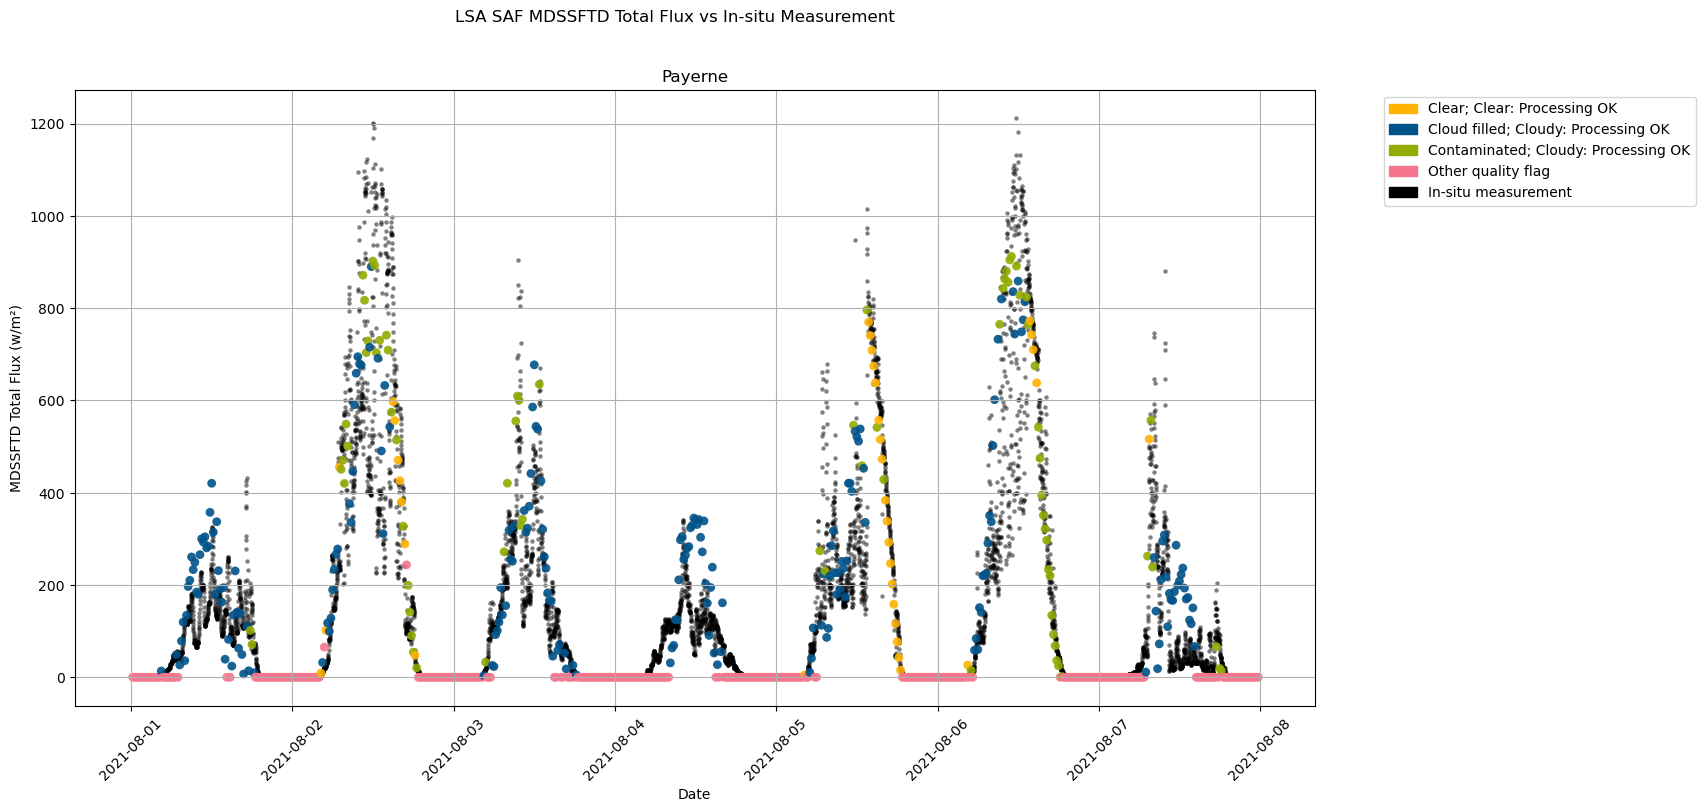

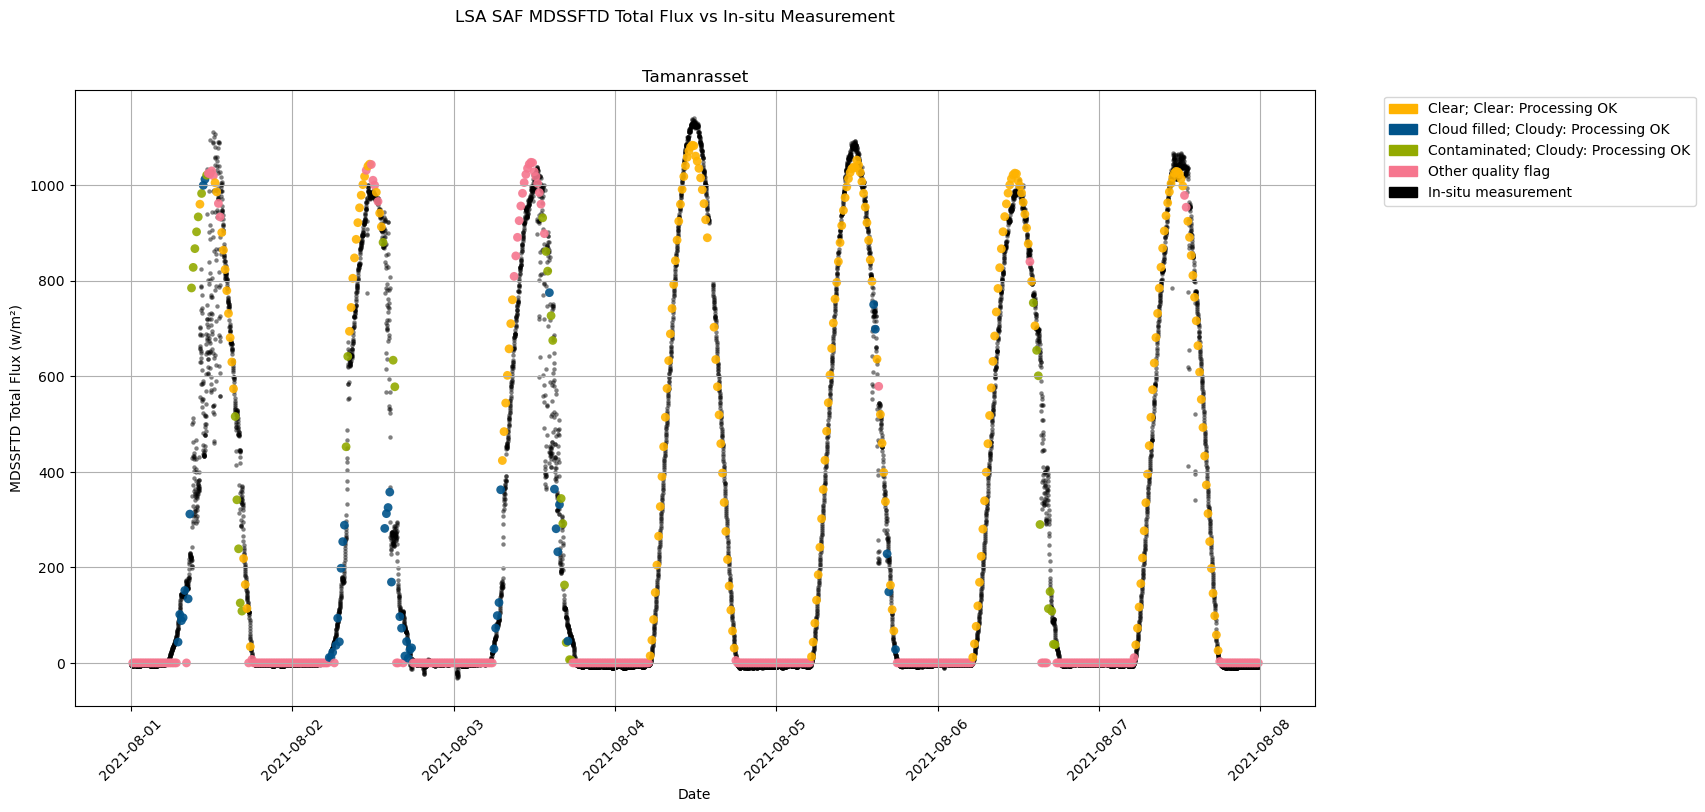

In [17]:
# Iterate over locations
for j, location in enumerate(locations):

    # Define figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=100)

    # Create a temporary dataframe and populate it with filtered values
    df_location = df.loc[df["name"] == location].copy()
    
    # Plot in-situ measurements
    ax.scatter(
        df_location["Date/Time"],
        df_location["SWD"],
        c="black",
        label="In Situ",
        s=10,
        alpha=0.5,
        edgecolors="grey",
        linewidths=0.01,
    )

    # Plot MDSSFTD estimates
    sc = ax.scatter(
        df_location["Date/Time"],
        df_location["TOTAL"],
        c=df_location["color"],
        marker="o",
        s=40.0,
        edgecolors="darkgrey",
        linewidths=0.01,
        alpha=0.9,
    )

    # Drop the temporrary dataframe
    del df_location

    # Create custom legend handles
    legend_handles = [
        Patch(color=color, label=label) for label, color in color_dict.items()
    ]

    # Add the custom legend to the plot
    ax.legend(
        handles=legend_handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    # Customize plot
    customize_subplot(
        ax,
        location,
        "Date",   # Specify x-label
        "MDSSFTD Total Flux (w/m²)", # Specify y-label
        suptitle="LSA SAF MDSSFTD Total Flux vs In-situ Measurement", # Specify suptitle
        legend=False, # Set legend to false, since it was constructed manually
    )

    # Save figure (uncomment)
    #plt.savefig(location+"_DSSF_no_shift.png")
    plt.show()

It can be observed, that Payerne experienced varying weather conditions and therefore total DSSF varied. This can be seen from the shape of the DSSF signal as well as also from the MDSSFTD quality flags indicating a significant amount of data points with cloudy or partially cloudy weather.

Furthermore, it is worth noting, that on 4 August 2024 MDSSFTD total flux stays zero, even when the in-situ measurements clearly show non-zero values (morning, evening). This can be explained with non-reliable measurement, which is confirmed by the look on the quality flag.

Tamnraset exhibited a higher amount of clear sky, and the LSA SAF estimations agree well with the in-situ results.

In the next cell, we will compare both measurements between themselves on the XY plot to see, how well they agree with each other. Since MDSSFTD and in-situ measurement have different sampling frequencies, we plot only instances, when we have both measurements available.

This "filtering" is actually done with `ax.scatter`, since `pyplot` only plots the data points, with both valid coordinates and ignores the instances with available in-situ measurements and missing MDSSFTD measurements, since there is `NaN` value passed as one of the coordinates for the data-points.

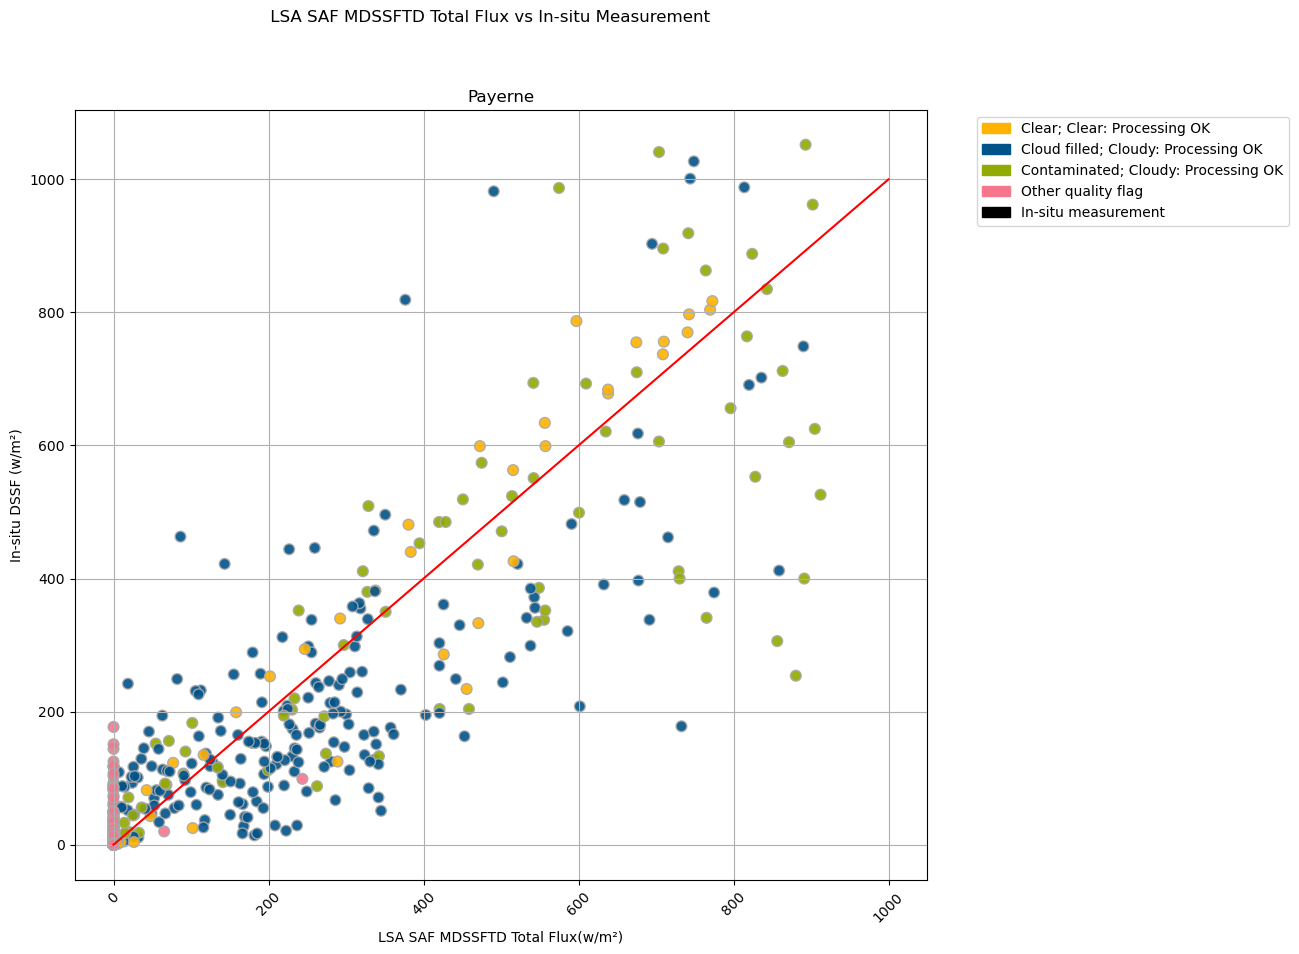

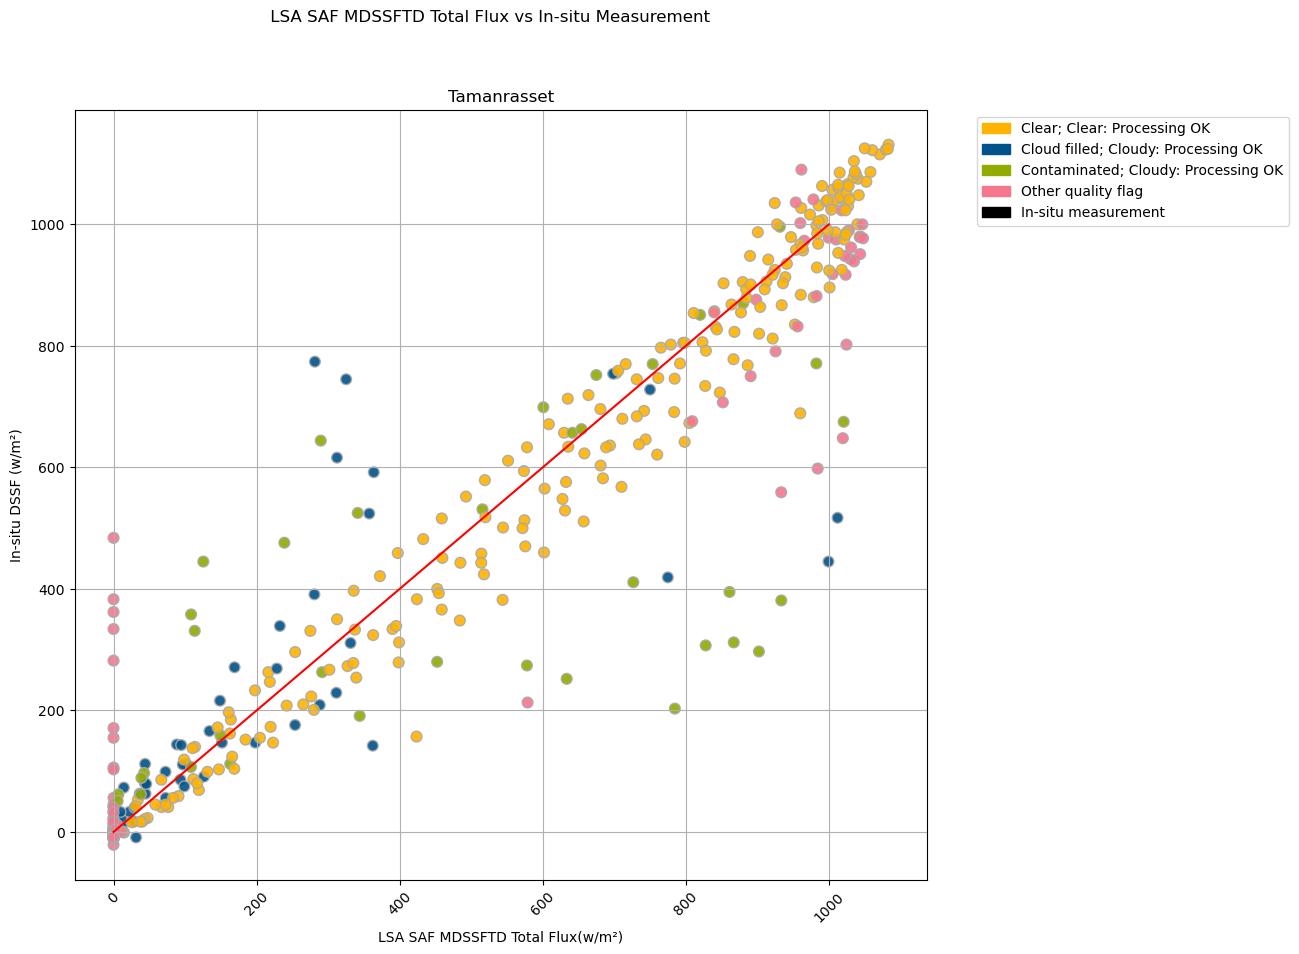

In [18]:
# Iterate over locations and years
for j, location in enumerate(locations):

    # Define figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), dpi=100)

    # Create a temporary dataframe and populate it with filtered values
    df_location = df.loc[df["name"] == location].copy()


    # Plot comparison of measurements
    sc = ax.scatter(
        df_location["TOTAL"],
        df_location["SWD"],
        marker="o",
        c=df_location["color"],
        s=60.0,
        edgecolors="darkgrey",
        linewidths=1,
        alpha=0.9,
    )

    # Plot y=x line
    ax.plot([0, 1000], [0,1000], c='red')

    # Drop the temporrary dataframe
    del df_location

    # Create custom legend handles
    legend_handles = [
        Patch(color=color, label=label) for label, color in color_dict.items()
    ]

    # Add the custom legend to the plot
    ax.legend(
        handles=legend_handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    # Customize plot
    customize_subplot(
        ax,
        location,
        "LSA SAF MDSSFTD Total Flux(w/m²)",
        "In-situ DSSF (w/m²)",
        suptitle=" LSA SAF MDSSFTD Total Flux vs In-situ Measurement",
        legend=False,
    )

    # Save figure (uncomment)
    #plt.savefig(location+"_DSSF_comparison_no_shift.png")
    plt.show()

The upper plots show how well MDSSFTD total flux and in-situ measurements agree with each other. The red line indicates the points, for which the measurements perfectly agree. Areas above this line indicate situations in which MDSSFTD underestimates total flux and the points below this line, areas where MDSSFTD overestimates total flux, compared to the in-situ measurement.

From both locations it can be concluded, that the yellow dots, indicating a clear sky lie closer to the red line than the green and blue dots, indicating a partially cloudy and cloudy sky. There are some clear outliers in both locations, where the MDSSFTD total flux estimate is zero, and in-situ measurement is nonzero, but it is clear from the quality flag info, that this measurement is not reliable.

The upper plots can also be understood as a [Lissajous curve](https://en.wikipedia.org/wiki/Lissajous_curve), which can in the case of 2 periodic signals with the same amplitude indicate the phase shift between the 2 measurements. In case of no phase shift, Lissajous curve becomes a red line on upper plots. Deviation from this line (or dots in an elliptic shape) could indicate some kind of systematic time shift between the two measurements.

### <a id='Fourth'></a>4. Calculating the Time Shift between the Beginning of the Sampling Interval and Actual Acquisition

There is an expected up to 12-min delay between in-situ and MDSSFTD measurements, since the time, indicated in LSA SAF products `NetCDF4` files, represents the beginning of the acquisition interval and not the time at which the pixel was actually measured. All pixels in MSG native projection (the native projection for LSA SAF products in `HDF5` files) are not measured at the same time. The MSG instrument takes measurements from south to north. The total time, needed to measure the full disk, is approximately 12 minutes. Therefore, each pixel is measured up to 12 minutes later and then imprinted in the product files.

A formula for estimation of such delay is available in the PUM but takes the row of the desired pixel in the `HDF5` file as an input and returns the delay in minutes.

Since we are working with `NetCDF4` files instead of `HDF5` we first need to figure out, which pixel in the `HDF5` file corresponds to the location with the certain latitude and longitude (coordinates used in the `NetCDF4` file). This can be achieved using `get_hdf5_index()` defined at the beginning of this JN. Function determines the closest pixel with the help of the auxiliary `HDF5` files. Then we input the row number to the `calculate_time_difference()` function and estimate the delay between the beginning of the acquisition and the time that the LSA SAF measurements for Tamanrasset and Payerne are actually measured.

In [19]:
# Iterate over locations
for location in locations:

    # Extract latitude and longitude
    lat = locations_df.loc[locations_df["name"] == location, "lat"].values
    lon = locations_df.loc[locations_df["name"] == location, "lon"].values

    # Calculate and print the time difference
    print(location + ": " + str(calculate_time_difference(get_hdf5_index(lat, lon))))

Payerne: 11.32
Tamanrasset: 9.163333333333332


We have indicated, that the measurement for Payerne is acquired 11.32 minutes later than nominal time and measurement for Tamanrasset 9.16 minutes later. In the next part we will therefore plot LSA SAF measurements with the time, when they were actually measured. We do that by creating a new column with adapted measurement times called `shifted Date/Time`. We populate this column with date shifted for 11.32 minutes or 9.16 minutes based on the location, which we filter by `df.loc([df["name"] == desired location])`.

In [20]:
# Create a new column
df["shifted Date/Time"] = df["Date/Time"]

# Populate column with the shifted datetime
df.loc[(df["name"] == "Payerne"), "shifted Date/Time"] += pd.Timedelta(minutes=11.32)
df.loc[(df["name"] == "Tamanrasset"), "shifted Date/Time"] += pd.Timedelta(minutes=9.16)

# Print the resulting dataframe
print(df.head(2))

                Date/Time         name  Elevation [m a.s.l.]  SWD  Unnamed: 5  \
0     2021-08-01 00:01:00      Payerne                   491    0         NaN   
1     2021-08-01 00:02:00      Payerne                   491    0         NaN   
2     2021-08-01 00:03:00      Payerne                   491    0         NaN   
3     2021-08-01 00:04:00      Payerne                   491    0         NaN   
4     2021-08-01 00:05:00      Payerne                   491    0         NaN   
...                   ...          ...                   ...  ...         ...   
54608 2021-08-07 23:41:00  Tamanrasset                  1385   -9         NaN   
54609 2021-08-07 23:42:00  Tamanrasset                  1385   -8         NaN   
54610 2021-08-07 23:43:00  Tamanrasset                  1385   -8         NaN   
54611 2021-08-07 23:44:00  Tamanrasset                  1385   -8         NaN   
54612 2021-08-07 23:45:00  Tamanrasset                  1385   -8         NaN   

       TOTAL  QUALITY FLAG 

### <a id='Fifth'></a>5. Plotting the DSSF with Shifted Acquisition Time

Now we will plot the MDSSFTD and in-situ estimates for total flux as a time series in a way similar to the first 2 examples in this JN. To make plots more clear, measurements won't be color-coded based on the quality flag, but will rather plot only reliable measurements.

We will achieve this, by adding condition `df['QUALITY FLAG'].isin(accepted_flags)`, when creating a temporary data frame with measurements from the same location. The `accepted_flags` list also includes `np.NaN`, since we want to include all in-situ measurements, which don't have a quality flag.

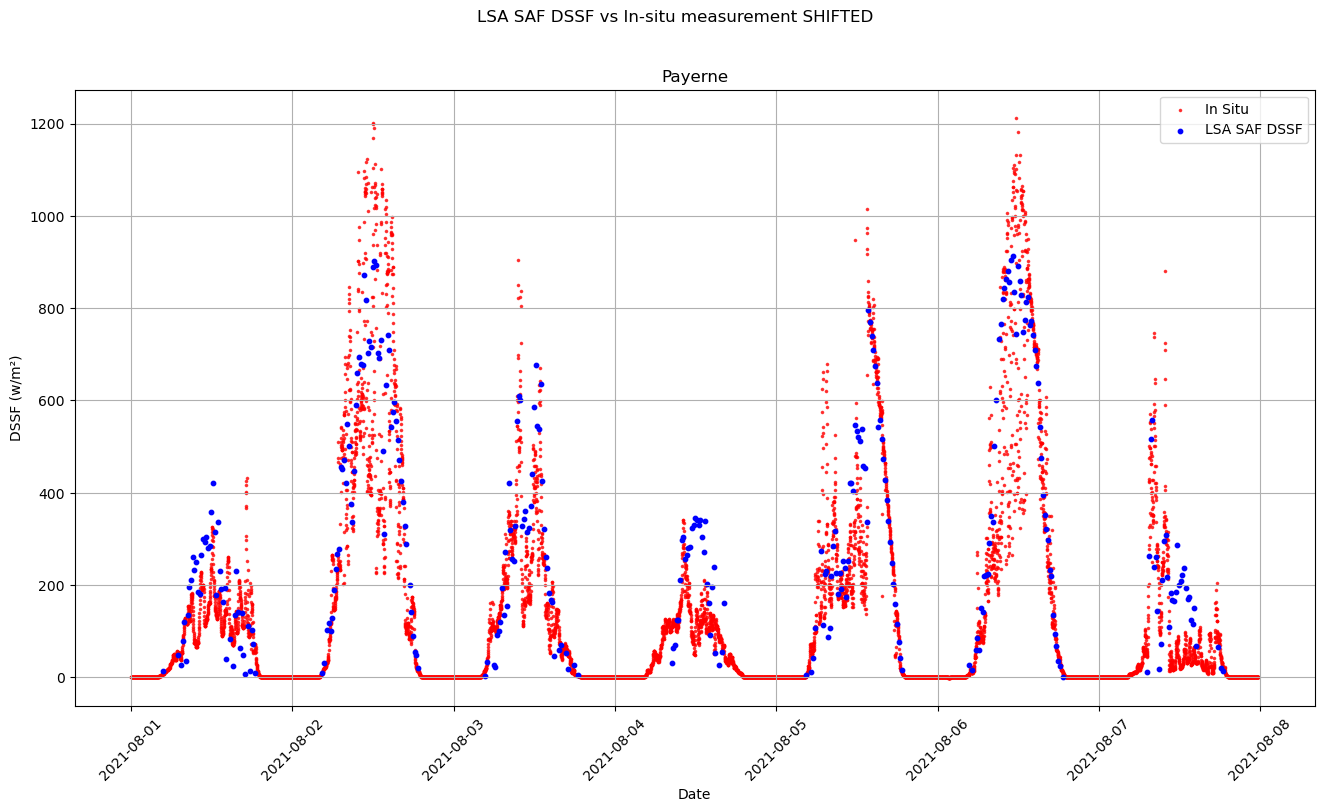

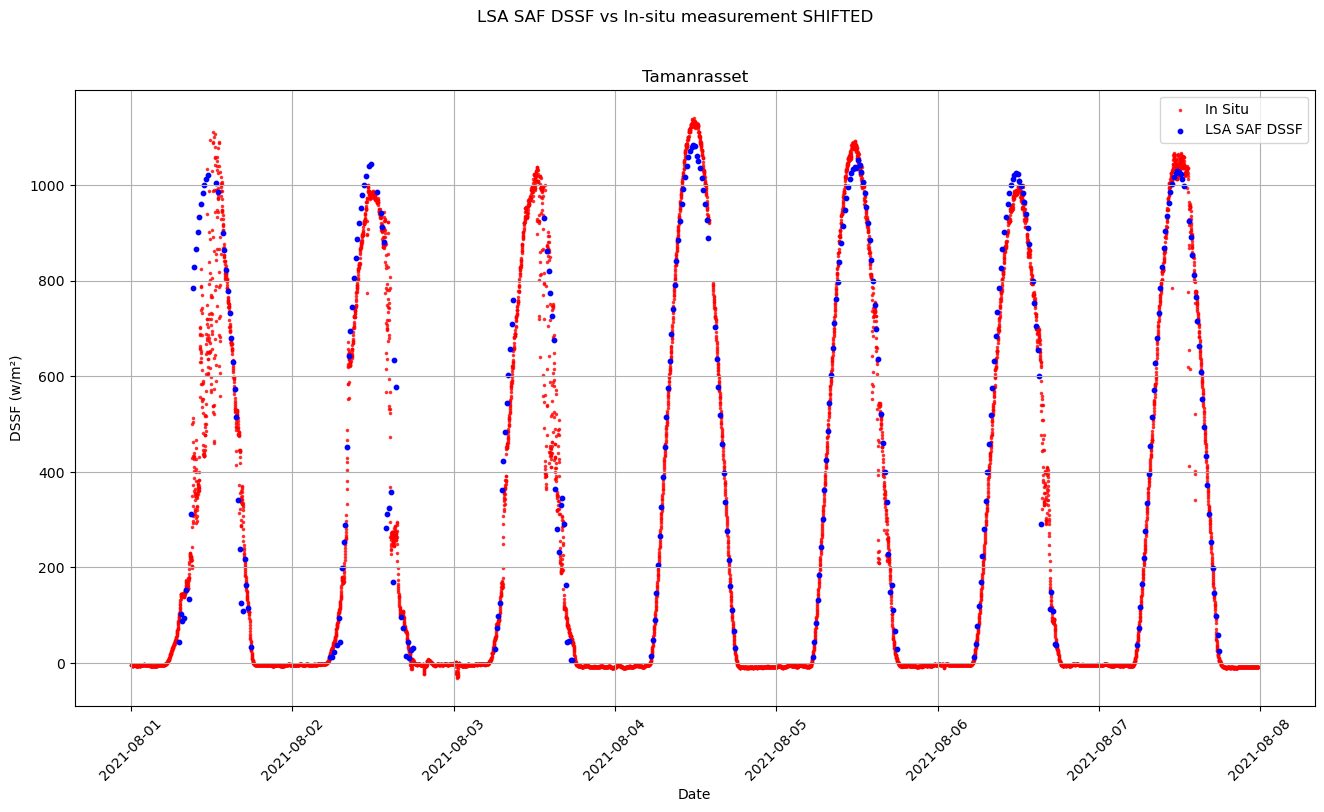

In [21]:
# Define a list of accepted quality flags
accepted_flags=[9.0, 13.0, 133.0, np.nan]

# Iterate over locations and years
for j, location in enumerate(locations):

    # Define figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=100)

    # Create a temporary dataframe and populate it with filtered values
    df_location = df.loc[(df["name"] == location) & (df['QUALITY FLAG'].isin(accepted_flags))].copy()

    # Plot in-situ measurements
    ax.scatter(
        df_location["Date/Time"],
        df_location["SWD"],
        c="red",
        label="In Situ",
        s=2.5,
        alpha=0.7
    )

    # Plot both sets of measurements
    ax.scatter(
        df_location["shifted Date/Time"],
        df_location["TOTAL"],
        c="blue",
        label="LSA SAF DSSF",
        s=10.0,
    )

    # Drop the temporrary dataframe
    del df_location

    # Customize plot
    customize_subplot(
        ax,
        location,
        "Date",
        r"DSSF (w/m²)",
        suptitle="LSA SAF DSSF vs In-situ measurement SHIFTED",
    )

    # Save figure (uncomment)
    #plt.savefig(location+"_DSSF_shift.png")
    plt.show()

From both plots, it can be observed, that MDSSFTD agrees well with in-situ measurement when the flux follows the theoretical bell-shaped curve, which appears in clear weather. Disproportionally small values of flux per se indicate clouds, therefore we can conclude, that both measurements agree well in clear weather.

Contrary, some differences persist in the case of cloudy weather, which can be easily indicated in the case of Payerne, where it can be seen (for instance 5 August 2021), that in-situ measurements with 1-minute sampling can detect fluctuations in total DSSF with smaller timescale compared to the MDSSFTD.

Furthermore, MDSSFTD is evaluated for a whole pixel, which can be larger than the shadows produced by the clouds. Therefore, MDSSFTD represents an average on the broader area compared to the in-situ measurement and is to some degree smoothed.

In the next section, we will compare the measurements as before and try to show, that taking time-delay into account improves agreement between MDSSFTD and in-situ measurement.

In this case, we can not just introduce a time delay, since we are plotting pairs of measurements as a single dot on the scatter plot, but we need to construct a new pair. In the previous case, we paired MDSSFTD estimation with in-situ measurements based on the nominal acquisition time of MDSSFTD. In this case, we need to shift the data for an integer value. We need to do that for both locations separately (since they have different shifts) and drop the ones, that are left without a pair. We use `numpy.shift()` to shift the data and sort the shifted values in a separate column of the data frame.

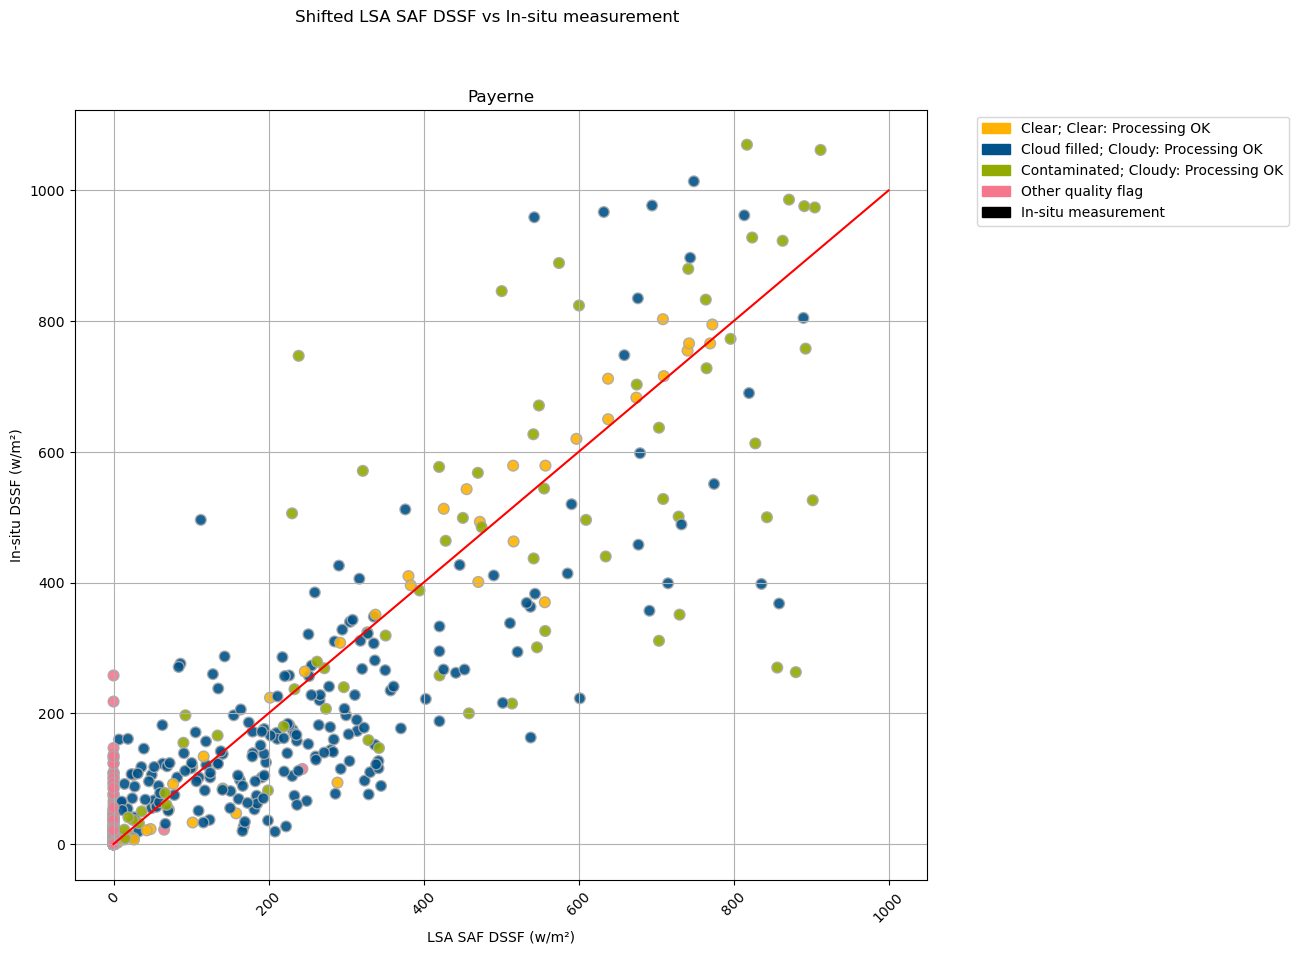

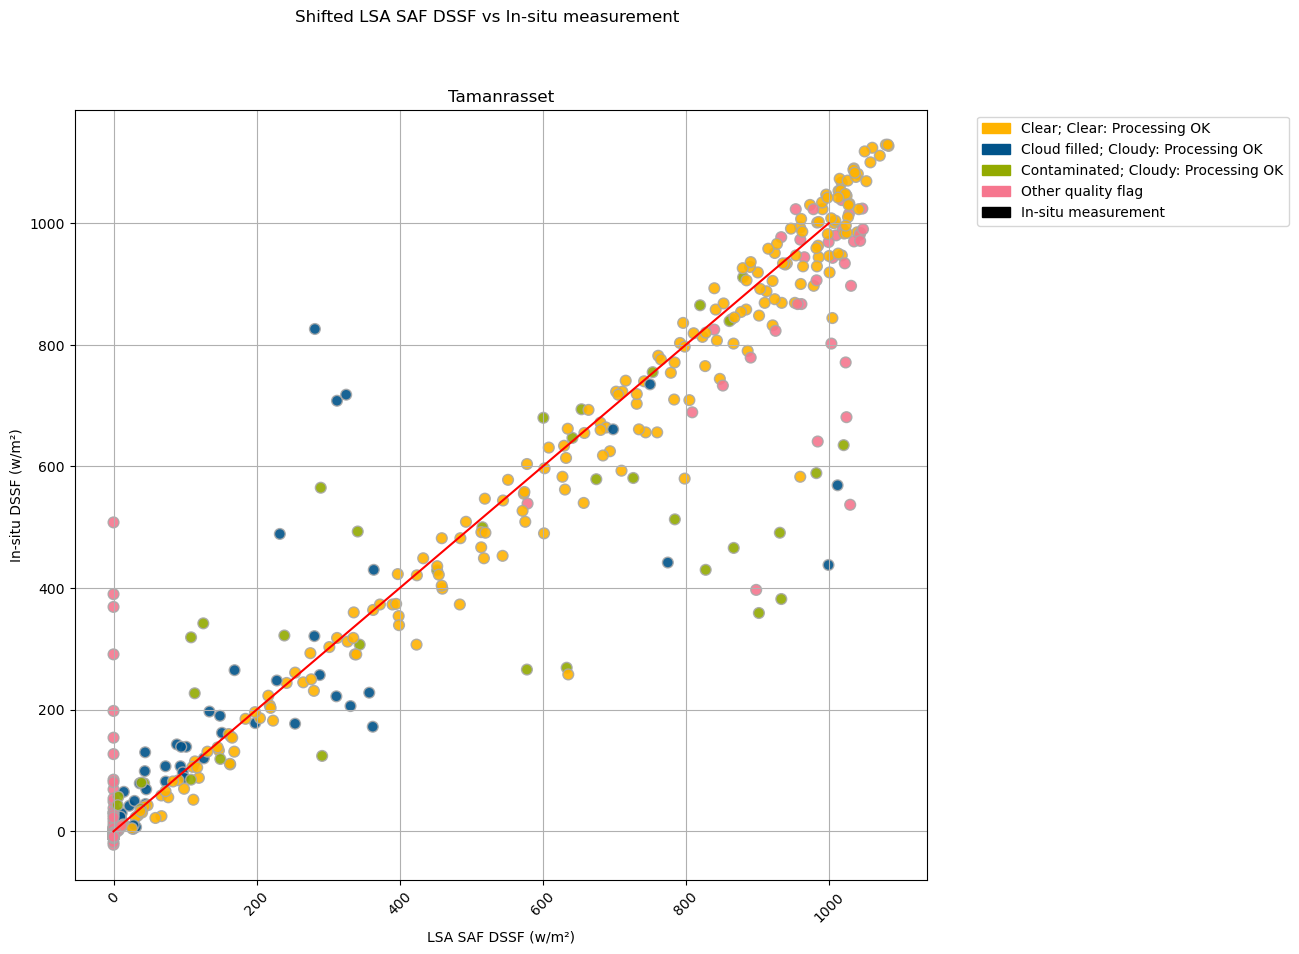

In [22]:
shifts = [11, 9]

# Iterate over locations and years
for j, location in enumerate(locations):

    # Define figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(11, 10), dpi=100)

    # Create a temporary dataframe and populate it with filtered values
    df_location = df.loc[df["name"] == location].copy()

    # Shift measurements
    df_location["shifted TOTAL"] = df_location["TOTAL"].shift(shifts[j])

    # Shift colors
    df_location["shifted color"] = df_location["color"].shift(shifts[j])
    
    # Drop entries without pair
    df_location=df_location.dropna(subset=['shifted TOTAL', 'SWD'])


    # Plot measurements comparison
    sc = ax.scatter(
        df_location["shifted TOTAL"],
        df_location["SWD"],
        marker="o",
        c=df_location["shifted color"],
        s=60.0,
        edgecolors="darkgrey",
        linewidths=1,
        alpha=0.9,
    )

    # Plot y=x line
    ax.plot([0, 1000], [0,1000], c='red')

    # Drop the temporrary dataframe
    del df_location

    # Create custom legend handles
    legend_handles = [
        Patch(color=color, label=label) for label, color in color_dict.items()
    ]

    # Add the custom legend to the plot
    ax.legend(
        handles=legend_handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    # Customize plot
    customize_subplot(
        ax,
        location,
        r"LSA SAF DSSF (w/m²)",
        "In-situ DSSF (w/m²)",
        suptitle="Shifted LSA SAF DSSF vs In-situ measurement",
        legend=False,
    )

    # Safe figure (uncomment)
    # plt.savefig(location+"_DSSF_comparison_shift.png")
    plt.show()

By looking at the resulting scatter plots, it can be concluded, that the MDSSFTD estimates agree with the in-situ measurements the best when the sky is clear. Furthermore, just by visually comparing the plots after and before taking time delay into account, we can observe, that the dispersion between the measurements is smaller when we take delay into account.

Particularly in the case of Payerne, we can see, that the measurements, acquired during the clear sky lie almost directly on the red line, indicating perfect agreement with in-situ estimates, which was not the case before applying the time shift.  

By comparing the scatter plots for Tamanrasset before and after the shift we can see, that the dispersion of measurements (once again we focus on yellow dots, indicating the best measurements with the clear sky) is narrower, which indicates smaller dispersion. Furthermore, one could speculate, that the dots before applying the time shift lie on the ellipse, which becomes much narrower after applying the time shift, although this effect is not completely visible, since the shape was already quite narrow at the beginning. This can indicate, that we decreased the phase shift between the 2 signals.

### <a id='Sixt'></a>6. Conclusion

We were able to compare MDSSFTD total flux estimations with in-situ estimations for 2 locations, Payerne in Central Europe and Tamanrasset in North Africa. It was demonstrated, that not all MDSSFTD product total flux estimations are reliable and the MDSSFTD product quality flag needs to be checked to obtain only reliable estimations.

Furthermore, when comparing the MDSSFTD estimations with in-situ total flux estimation with higher sampling frequency we were able to demonstrate the delay between the beginning of the MSG acquisition interval and the time of actual measurement of a particular pixel, which needs to be taken into account. A computation of this delay and applying the corresponding shift in acquisition time was also demonstrated.

#### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 27.3.2024.
* Vuilleumier, Laurent (2022): Ultra-violet measurements from station Payerne (2021-08) [dataset]. *Swiss Meteorological Agency, Payerne, PANGAEA*, [https://doi.org/10.1594/PANGAEA.941791](https://doi.org/10.1594/PANGAEA.941791)
* Baika, Sidi; Saanoune, Abdessadak (2021): Basic measurements of radiation at station Tamanrasset (2021-08) [dataset]. *National Meteorological Office of Algeria, PANGAEA*, [https://doi.org/10.1594/PANGAEA.935908](https://doi.org/10.1594/PANGAEA.935908), *In:* Baika, Sidi; Saanoune, Abdessadak; Mimouni, Mohamed (2024): Basic measurements of radiation at station Tamanrasset (2000-03 et seq) [dataset publication series]. *National Meteorological Office of Algeria, PANGAEA*, [https://doi.org/10.1594/PANGAEA.965124](https://doi.org/10.1594/PANGAEA.965124)